In [1]:
import numpy as np
import torch, torchvision
from torch.utils.data import Dataset, DataLoader
import torch.nn as nn
import torch.nn.functional as F
from functools import partial
import matplotlib.pyplot as plt
#from random import randrange
#import cv2
from torchsummary import summary

In [2]:
def image_show(img):
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1,2,0)))
    plt.show()
def get_image(i_dim, n_dim, n_pos , n_strength, pos_scale):
    image = torch.zeros((3, i_dim,i_dim))
    if isinstance(n_pos, torch.Tensor):
        i_n_pos = (n_pos * pos_scale).type(torch.int)
    else:
        i_n_pos = (n_pos * pos_scale).astype(int)
    #print(i_n_pos[0])
    for c in range(3): #to get it equal over all chanels 
        image[c, i_n_pos[0].item():(i_n_pos[0].item() + n_dim),i_n_pos[1].item():(i_n_pos[1].item()+n_dim)] = n_strength
    return image
def net_show(n_pos, i_dim=64, n_dim=3, n_strength=torch.ones((3,3)), pos_scale=62):
    with torch.no_grad():
        npn_pos = n_pos.numpy()
        npn_pos = np.transpose(npn_pos, (1,2,0))
        for batch in npn_pos:
            red_n_pos = np.array([batch[0][0], batch[1][0]])
            print(red_n_pos)
            image = get_image(i_dim, n_dim, red_n_pos, n_strength, pos_scale)
            image_show(image)

In [3]:
i_dim = 64
n_dim = 3
PATH_DATA = './pixel_finder_data.pth'
sample_size = 200000

In [4]:
class ImagePositionDataset(Dataset):
    def __init__(self, i_dim, n_dim, sample_size, path=""):
        self.i_dim = i_dim
        self.n_dim = n_dim
        self.pos_scale = i_dim-n_dim+1
        if path != "": #load the data
            self.load(path, i_dim, n_dim)
            assert sample_size == self.sample_size
        else: #create new data
            self.sample_size = sample_size
            self.data = []
            for i in range(sample_size):
                n_pos = torch.flatten(torch.rand((1,2)))
                n_strength = torch.rand((3,3))#np.random.rand(n_dim, n_dim) #one chanel
                self.data.append((n_pos, n_strength))
        
    def __len__(self):
        return self.sample_size
    
    def __getitem__(self, idx):
        sample = (get_image(self.i_dim, self.n_dim, self.data[idx][0], self.data[idx][1], self.pos_scale), self.data[idx][0], self.pos_scale)
        return sample
    
    def save(self, path):
        torch.save(self.data, path)
        
    def load(self, path, i_dim, n_dim):
        self.data = torch.load(path)
        self.sample_size = len(self.data)

In [5]:
#new dataset
image_dataset = ImagePositionDataset(i_dim, n_dim, sample_size)
image_dataset.save(PATH_DATA)
dataloader = DataLoader(image_dataset, batch_size=4,
                        shuffle=True, num_workers=0)

In [6]:
#load dataset
image_dataset = ImagePositionDataset(i_dim, n_dim, sample_size, path=PATH_DATA)
dataloader = DataLoader(image_dataset, batch_size=4,
                        shuffle=True, num_workers=0)

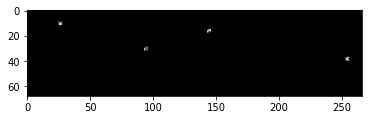

In [7]:
dataiter = iter(dataloader)
images, labels, scales = dataiter.next()
image_show(torchvision.utils.make_grid(images))
#net(images)

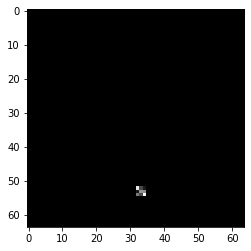

In [8]:
image,_,_ = image_dataset[0]
image_show(image)

In [9]:
net(image.unsqueeze(0));

NameError: name 'net' is not defined

In [10]:
learning_rate = 0.00001
num_epoch = 2
PATH = './pixel_finder.pth'

In [11]:
class Conv2dAuto(nn.Conv2d):
    def __init__(self, *args, **kwargs):
        super().__init__(*args, **kwargs)
        self.padding =  (self.kernel_size[0] // 2, self.kernel_size[1] // 2) # dynamic add padding based on the kernel_size

conv3x3 = partial(Conv2dAuto, kernel_size=3, bias=False)

def activation_func(activation):
    return  nn.ModuleDict([
        ['relu', nn.ReLU(inplace=True)],
        ['leaky_relu', nn.LeakyReLU(negative_slope=0.01, inplace=True)],
        ['selu', nn.SELU(inplace=True)],
        ['none', nn.Identity()]
    ])[activation]

class ResidualBlock(nn.Module):
    def __init__(self, in_channels, out_channels, activation='relu'):
        super().__init__()
        self.in_channels, self.out_channels, self.activation = in_channels, out_channels, activation
        self.blocks = nn.Identity()
        self.activate = activation_func(activation)
        self.shortcut = nn.Identity()   
    
    def forward(self, x):
        residual = x
        if self.should_apply_shortcut: residual = self.shortcut(x)
        x = self.blocks(x)
        x += residual
        x = self.activate(x)
        return x
    
    @property
    def should_apply_shortcut(self):
        return self.in_channels != self.out_channels
    
class ResNetResidualBlock(ResidualBlock):
    def __init__(self, in_channels, out_channels, expansion=1, downsampling=1, conv=conv3x3, *args, **kwargs):
        super().__init__(in_channels, out_channels, *args, **kwargs)
        self.expansion, self.downsampling, self.conv = expansion, downsampling, conv
        self.shortcut = nn.Sequential(
            nn.Conv2d(self.in_channels, self.expanded_channels, kernel_size=1,
                      stride=self.downsampling, bias=False), 
                      nn.BatchNorm2d(self.expanded_channels)) if self.should_apply_shortcut else None #nn.Identity() ?
            
        
        
    @property
    def expanded_channels(self):
        return self.out_channels * self.expansion
    
    @property
    def should_apply_shortcut(self):
        return self.in_channels != self.expanded_channels
    
    
def conv_bn(in_channels, out_channels, conv, *args, **kwargs):
    return nn.Sequential(conv(in_channels, out_channels, *args, **kwargs), nn.BatchNorm2d(out_channels))



class ResNetBasicBlock(ResNetResidualBlock):
    """
    Basic ResNet block composed by two layers of 3x3conv/batchnorm/activation
    """
    expansion = 1
    def __init__(self, in_channels, out_channels, *args, **kwargs):
        super().__init__(in_channels, out_channels, *args, **kwargs)
        self.blocks = nn.Sequential(
            conv_bn(self.in_channels, self.out_channels, conv=self.conv, bias=False, stride=self.downsampling),
            activation_func(self.activation),
            conv_bn(self.out_channels, self.expanded_channels, conv=self.conv, bias=False),
        )
    
class ResNetBottleNeckBlock(ResNetResidualBlock):
    expansion = 4
    def __init__(self, in_channels, out_channels, *args, **kwargs):
        super().__init__(in_channels, out_channels, expansion=4, *args, **kwargs)
        self.blocks = nn.Sequential(
           conv_bn(self.in_channels, self.out_channels, self.conv, kernel_size=1),
             activation_func(self.activation),
             conv_bn(self.out_channels, self.out_channels, self.conv, kernel_size=3, stride=self.downsampling),
             activation_func(self.activation),
             conv_bn(self.out_channels, self.expanded_channels, self.conv, kernel_size=1),
        )
        
class ResNetLayer(nn.Module):
    """
    A ResNet layer composed by `n` blocks stacked one after the other
    """
    def __init__(self, in_channels, out_channels, block=ResNetBasicBlock, n=1, *args, **kwargs):
        super().__init__()
        # 'We perform downsampling directly by convolutional layers that have a stride of 2.'
        downsampling = 2 if in_channels != out_channels else 1
        self.blocks = nn.Sequential(
            block(in_channels , out_channels, *args, **kwargs, downsampling=downsampling),
            *[block(out_channels * block.expansion, 
                    out_channels, downsampling=1, *args, **kwargs) for _ in range(n - 1)]
        )

    def forward(self, x):
        x = self.blocks(x)
        return x
    
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        
        self.conv = ResNetLayer(3, 16, block=ResNetBasicBlock, n=2)
        self.fc1 = nn.Linear(32*32*16 , 1024)
        self.fc2 = nn.Linear(1024,2)
        self.sig = nn.Sigmoid()
        self.drop_out = nn.Dropout(p=0.2)


    def forward(self, x):
        out = self.conv(x)
        out = out.view(out.size(0), -1)
        out = self.fc1(out)
        out = F.relu(out)
        out = self.fc2(out)
        out = self.sig(out)
        
        return out


net = Net()

In [12]:
summary(net.cuda(), input_size=(3,64,64))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 16, 32, 32]              48
       BatchNorm2d-2           [-1, 16, 32, 32]              32
        Conv2dAuto-3           [-1, 16, 32, 32]             432
       BatchNorm2d-4           [-1, 16, 32, 32]              32
              ReLU-5           [-1, 16, 32, 32]               0
        Conv2dAuto-6           [-1, 16, 32, 32]           2,304
       BatchNorm2d-7           [-1, 16, 32, 32]              32
              ReLU-8           [-1, 16, 32, 32]               0
  ResNetBasicBlock-9           [-1, 16, 32, 32]               0
       Conv2dAuto-10           [-1, 16, 32, 32]           2,304
      BatchNorm2d-11           [-1, 16, 32, 32]              32
             ReLU-12           [-1, 16, 32, 32]               0
       Conv2dAuto-13           [-1, 16, 32, 32]           2,304
      BatchNorm2d-14           [-1, 16,

In [13]:
#Load net
#net.load_state_dict(torch.load(PATH))

In [14]:
loss_fn = torch.nn.MSELoss(reduction='sum') #mean besser?
optimizer = torch.optim.Adam(net.parameters(), lr=learning_rate)

In [15]:
net=net.cuda()
for epoch in range(num_epoch):
    running_loss = 0.0
    for i_batch, sample_batched in enumerate(dataloader):
        inputs,labels,_ = sample_batched
        #print(len(inputs))
        inputs,labels = inputs.cuda(), labels.cuda()
        
        optimizer.zero_grad()
        outputs = net(inputs)
        
        #print(outputs)
        loss = loss_fn(outputs, labels)
        #print(loss)
        
        loss.backward()
        optimizer.step()
        running_loss += loss.item()
        if i_batch % 20 == 19:    # print every 2000 mini-batches
            print('[%d, %5d] loss: %.3f' %(epoch + 1, i_batch + 1, running_loss / (20*4)))
            running_loss = 0.0

print('Finished Training')

[1,    20] loss: 0.161
[1,    40] loss: 0.087
[1,    60] loss: 0.051
[1,    80] loss: 0.037
[1,   100] loss: 0.024
[1,   120] loss: 0.014
[1,   140] loss: 0.013
[1,   160] loss: 0.012
[1,   180] loss: 0.012
[1,   200] loss: 0.014
[1,   220] loss: 0.013
[1,   240] loss: 0.011
[1,   260] loss: 0.009
[1,   280] loss: 0.009
[1,   300] loss: 0.007
[1,   320] loss: 0.008
[1,   340] loss: 0.007
[1,   360] loss: 0.008
[1,   380] loss: 0.007
[1,   400] loss: 0.009
[1,   420] loss: 0.008
[1,   440] loss: 0.007
[1,   460] loss: 0.007
[1,   480] loss: 0.006
[1,   500] loss: 0.007
[1,   520] loss: 0.007
[1,   540] loss: 0.007
[1,   560] loss: 0.008
[1,   580] loss: 0.006
[1,   600] loss: 0.009
[1,   620] loss: 0.006
[1,   640] loss: 0.008
[1,   660] loss: 0.005
[1,   680] loss: 0.007
[1,   700] loss: 0.007
[1,   720] loss: 0.007
[1,   740] loss: 0.005
[1,   760] loss: 0.007
[1,   780] loss: 0.007
[1,   800] loss: 0.007
[1,   820] loss: 0.007
[1,   840] loss: 0.006
[1,   860] loss: 0.008
[1,   880] 

KeyboardInterrupt: 

In [16]:
#test dataset
image_dataset_test = ImagePositionDataset(i_dim, n_dim, sample_size, path="")
dataloader_test = DataLoader(image_dataset_test, batch_size=4, shuffle=True, num_workers=0)
dataiter_test = iter(dataloader_test)
images, labels, scales = dataiter_test.next()
images_cuda, labels = images.cuda(), labels.cuda()

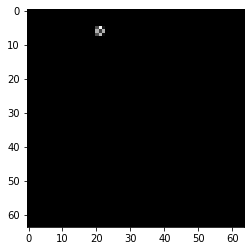

tensor([0.0637, 0.2655], device='cuda:0', grad_fn=<UnbindBackward>)


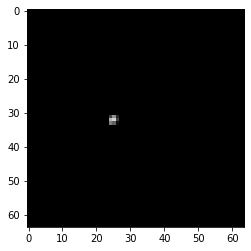

tensor([0.4685, 0.3817], device='cuda:0', grad_fn=<UnbindBackward>)


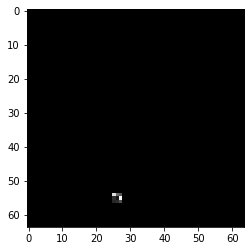

tensor([0.8612, 0.4018], device='cuda:0', grad_fn=<UnbindBackward>)


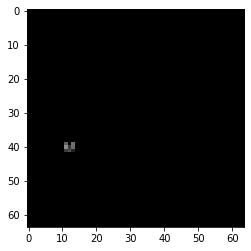

tensor([0.5751, 0.2662], device='cuda:0', grad_fn=<UnbindBackward>)


In [17]:
outputs=net(images_cuda)
for i, output in enumerate(outputs):
    image_show(torchvision.utils.make_grid(images[i]))
    print(output)